In [5]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('finally2.csv')

In [6]:
df.head()

,cntr_grnds_dstnc,frstn_grnds_dstnc,hr_unit_artmp,hr_unit_hum,hr_unit_wspd_info,growing_stock,forest_ratio,avg_growing_stock,t2m_mean_c,t2m_min_c,...,fnd_igtn_pstn_nm_plain,wndrct_brng_NONE,wndrct_brng_south,wndrct_brng_southeast,wndrct_brng_southwest,wndrct_brng_east,wndrct_brng_north,wndrct_brng_northeast,wndrct_brng_northwest,wndrct_brng_west
0,1.609438,2.484907,-1.0,39.0,1,30500,22.81,81.77,-3.034902,-5.790863,...,0,0,0,0,0,0,0,0,1,0
1,1.098612,1.609438,5.0,60.0,1,30500,22.81,81.77,4.081675,-0.366791,...,0,0,0,0,1,0,0,0,0,0
2,1.791759,2.302585,7.0,49.0,1,30500,22.81,81.77,5.162099,0.126862,...,0,0,0,0,1,0,0,0,0,0
3,1.098612,1.791759,0.3,48.0,3,512610,70.18,148.11,3.929311,-0.390961,...,0,0,0,0,0,0,0,0,1,0
4,2.397895,3.295837,-8.7,36.0,5,9313181,78.60,179.32,-5.911774,-7.743500,...,1,0,0,0,0,0,0,0,0,1


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [8]:
# 파일 경로
CSV_PATH = "finally2.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "fire_supesn_hr"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 모델에서 제외할 컬럼(있으면 제거)
EXCLUDE_COLS = {
    "total_time", "fire_supesn_hr", "relax_diff", "wind_speed_mean",
    TARGET  # 타깃은 당연히 피처에서 제외
}

# 숫자형 컬럼만 사용(원-핫 완료 가정) + 제외 컬럼 제거
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in EXCLUDE_COLS]

# 필요 시 누수 변수 제거 (새 데이터에 없으면 자동 무시)
LEAKY_COL = "ARRIVAL_DELAY_MIN_LOG"
if not INCLUDE_LEAKY and LEAKY_COL in feature_cols:
    feature_cols.remove(LEAKY_COL)

# 안전장치: 피처가 하나도 없으면 에러
if len(feature_cols) == 0:
    raise ValueError("선택된 피처가 없습니다. EXCLUDE_COLS 또는 전처리를 확인하세요.")

print(f"선택된 피처 수: {len(feature_cols)}")
print("제외된 컬럼(데이터에 존재했던 항목만):",
      sorted([c for c in EXCLUDE_COLS if c in df.columns]))

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")

행: 3,560, 열: 65

컬럼명:
 ['cntr_grnds_dstnc', 'frstn_grnds_dstnc', 'hr_unit_artmp', 'hr_unit_hum', 'hr_unit_wspd_info', 'growing_stock', 'forest_ratio', 'avg_growing_stock', 't2m_mean_c', 't2m_min_c', 't2m_max_c', 'd2m_mean_c', 'd2m_min_c', 'd2m_max_c', 'u10_mean_ms', 'v10_mean_ms', 'wind_speed_mean', 'wind_dir_deg', 'tp_sum_mm', 'pev_sum_mm', 'ssrd_sum_jm2', 'ssrd_sum_mjm2', 'impute_radius', 'land', 'arrival_time_diff', 'dispatch_time_diff', 'golden_time_under_50min', 'is_night', 'month_rcpt', 'dspt_req_hr', 'fire_supesn_hr', 'ctpv_nm_gangwon', 'ctpv_nm_gyeonggi', 'ctpv_nm_gyeongnam', 'ctpv_nm_gyeongbuk', 'ctpv_nm_gwangju', 'ctpv_nm_daegu', 'ctpv_nm_daejeon', 'ctpv_nm_busan', 'ctpv_nm_seoul', 'ctpv_nm_sejong', 'ctpv_nm_ulsan', 'ctpv_nm_incheon', 'ctpv_nm_jeonnam', 'ctpv_nm_jeonbuk', 'ctpv_nm_jeju', 'ctpv_nm_chungnam', 'ctpv_nm_chungbuk', 'fclt_plc_sclsf_nm_public', 'fclt_plc_sclsf_nm_national']  ...


,cntr_grnds_dstnc,frstn_grnds_dstnc,hr_unit_artmp,hr_unit_hum,hr_unit_wspd_info,growing_stock,forest_ratio,avg_growing_stock,t2m_mean_c,t2m_min_c,...,fnd_igtn_pstn_nm_plain,wndrct_brng_NONE,wndrct_brng_south,wndrct_brng_southeast,wndrct_brng_southwest,wndrct_brng_east,wndrct_brng_north,wndrct_brng_northeast,wndrct_brng_northwest,wndrct_brng_west
0,1.609438,2.484907,-1.0,39.0,1,30500,22.81,81.77,-3.034902,-5.790863,...,0,0,0,0,0,0,0,0,1,0
1,1.098612,1.609438,5.0,60.0,1,30500,22.81,81.77,4.081675,-0.366791,...,0,0,0,0,1,0,0,0,0,0
2,1.791759,2.302585,7.0,49.0,1,30500,22.81,81.77,5.162099,0.126862,...,0,0,0,0,1,0,0,0,0,0
3,1.098612,1.791759,0.3,48.0,3,512610,70.18,148.11,3.929311,-0.390961,...,0,0,0,0,0,0,0,0,1,0
4,2.397895,3.295837,-8.7,36.0,5,9313181,78.60,179.32,-5.911774,-7.743500,...,1,0,0,0,0,0,0,0,0,1


선택된 피처 수: 63
제외된 컬럼(데이터에 존재했던 항목만): ['fire_supesn_hr', 'wind_speed_mean']

최종 데이터 크기: X=(3558, 63), y=(3558,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [13]:
# === 0) 기본 설정 & Train/Test 분리 ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 전제: X, y 가 이미 준비되어 있음 (pandas DataFrame / Series 권장)
assert 'X' in globals() and 'y' in globals(), "먼저 X, y를 준비하세요."

RANDOM_STATE = 42
TEST_SIZE    = 0.2      # 80/20 분리
TARGET_IS_LOG = True    # y가 log1p 스케일이면 True (expm1로 복원용)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}  Test: {X_test.shape}")


Train: (2846, 63)  Test: (712, 63)


In [14]:
# === 1) 하이퍼파라미터 최적화 (Train 전용, 5-fold CV) ===
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def optimize_hyperparameters_rf(X_tr, y_tr, random_state=42):
    """
    RandomForest 하이퍼파라미터 그리드 탐색 (5-fold, MSE 기준)
    """
    print("=== [Step 1] 하이퍼파라미터 최적화 (Train 전용) ===")
    rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)

    param_grid = {
        'n_estimators': [100, 200, 400],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
    }

    gscv = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',   # RMSE 쓰려면 'neg_root_mean_squared_error'도 가능
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    gscv.fit(X_tr, y_tr)

    best_params = gscv.best_params_
    best_mse = -gscv.best_score_

    print(f"\n최적 하이퍼파라미터: {best_params}")
    print(f"최적 CV MSE: {best_mse:,.6f} (RMSE={np.sqrt(best_mse):,.6f})")

    return best_params

# 실행
best_params = optimize_hyperparameters_rf(X_train, y_train, random_state=RANDOM_STATE)
print("\n[Step 1 결과] best_params =", best_params)


=== [Step 1] 하이퍼파라미터 최적화 (Train 전용) ===
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

최적 하이퍼파라미터: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
최적 CV MSE: 0.934784 (RMSE=0.966842)

[Step 1 결과] best_params = {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


In [15]:
# === 2) 고정 하이퍼파라미터로 10번 반복(CV=5) → 베스트 run 선택 ===
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

def model_factory_rf(best_params, seed, n_jobs=-1):
    """seed만 바꿔 동일 하이퍼파라미터 RF 생성"""
    return RandomForestRegressor(random_state=seed, n_jobs=n_jobs, **best_params)

def pick_best_model_over_runs(X_tr, y_tr, best_params, n_runs=10, n_splits=5, base_seed=1000):
    """
    고정된 하이퍼파라미터로 서로 다른 seed로 10번 반복.
    각 run마다 5-fold CV를 돌려 '평균 MSE'가 가장 낮은 run을 베스트로 선정.
    선정된 run의 seed로 Train 전체 재학습한 모델 반환.
    """
    print("\n=== [Step 2] 10번 반복 CV → 베스트 run 선택 ===")
    run_summaries = []
    best_run_idx = None
    best_cv_mse = np.inf
    seeds = [base_seed + i for i in range(n_runs)]

    for i, seed in enumerate(seeds, start=1):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        fold_mse = []

        for tr_idx, va_idx in kf.split(X_tr):
            X_tr_fold, X_va_fold = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
            y_tr_fold, y_va_fold = y_tr.iloc[tr_idx], y_tr.iloc[va_idx]

            model = model_factory_rf(best_params, seed=seed)
            model.fit(X_tr_fold, y_tr_fold)
            y_va_pred = model.predict(X_va_fold)
            mse = mean_squared_error(y_va_fold, y_va_pred)
            fold_mse.append(mse)

        cv_mse = float(np.mean(fold_mse))
        cv_rmse = float(np.sqrt(cv_mse))
        run_summaries.append((seed, cv_mse, cv_rmse))
        print(f"[Run {i:02d} | seed={seed}] CV MSE={cv_mse:.6f} (RMSE={cv_rmse:.6f})")

        if cv_mse < best_cv_mse:
            best_cv_mse = cv_mse
            best_run_idx = i - 1  # 0-based

    best_seed, best_mse, best_rmse = run_summaries[best_run_idx]
    print(f"\n>>> 베스트 run: #{best_run_idx+1} (seed={best_seed})  "
          f"CV MSE={best_mse:.6f} (RMSE={best_rmse:.6f})")

    # 베스트 run의 seed로 Train 전체 재학습
    best_model = model_factory_rf(best_params, seed=best_seed)
    best_model.fit(X_tr, y_tr)

    return best_model, run_summaries

# 실행
best_model, run_summaries = pick_best_model_over_runs(
    X_train, y_train, best_params, n_runs=10, n_splits=5, base_seed=1000
)

print("\n[Step 2 결과] run 요약 (seed, CV MSE, CV RMSE):")
for seed, mse, rmse in run_summaries:
    print(f"  seed={seed} | MSE={mse:.6f} | RMSE={rmse:.6f}")



=== [Step 2] 10번 반복 CV → 베스트 run 선택 ===
[Run 01 | seed=1000] CV MSE=0.937016 (RMSE=0.967996)
[Run 02 | seed=1001] CV MSE=0.925105 (RMSE=0.961824)
[Run 03 | seed=1002] CV MSE=0.922506 (RMSE=0.960472)
[Run 04 | seed=1003] CV MSE=0.929858 (RMSE=0.964291)
[Run 05 | seed=1004] CV MSE=0.931972 (RMSE=0.965387)
[Run 06 | seed=1005] CV MSE=0.926469 (RMSE=0.962532)
[Run 07 | seed=1006] CV MSE=0.935472 (RMSE=0.967198)
[Run 08 | seed=1007] CV MSE=0.923031 (RMSE=0.960745)
[Run 09 | seed=1008] CV MSE=0.933307 (RMSE=0.966078)
[Run 10 | seed=1009] CV MSE=0.932378 (RMSE=0.965597)

>>> 베스트 run: #3 (seed=1002)  CV MSE=0.922506 (RMSE=0.960472)

[Step 2 결과] run 요약 (seed, CV MSE, CV RMSE):
  seed=1000 | MSE=0.937016 | RMSE=0.967996
  seed=1001 | MSE=0.925105 | RMSE=0.961824
  seed=1002 | MSE=0.922506 | RMSE=0.960472
  seed=1003 | MSE=0.929858 | RMSE=0.964291
  seed=1004 | MSE=0.931972 | RMSE=0.965387
  seed=1005 | MSE=0.926469 | RMSE=0.962532
  seed=1006 | MSE=0.935472 | RMSE=0.967198
  seed=1007 | MSE=0.9

In [16]:
# === 3) 베스트 모델로 Test 평가 (로그/원 단위) ===
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_on_test(best_model, X_te, y_te, target_is_log=True, time_unit="min", show_both=True):
    """로그 스케일/원 단위 지표 동시 출력"""
    def to_unit(v_sec, unit="sec"):
        if unit == "min":  return v_sec / 60.0
        if unit == "hour": return v_sec / 3600.0
        return v_sec
    def unit_label(unit):
        return {"sec":"초", "min":"분", "hour":"시간"}[unit]
    def hhmm(v_sec):
        v_sec = float(v_sec); h = int(v_sec // 3600); m = int((v_sec % 3600) // 60)
        return f"{h}h {m}m"
    def show(name, v_sec):
        main = to_unit(v_sec, time_unit)
        s = f"{name}: {main:,.2f} {unit_label(time_unit)}"
        if show_both:
            other = {"sec":"min", "min":"hour", "hour":"min"}[time_unit]
            s += f"  |  ({to_unit(v_sec, other):,.2f} {unit_label(other)}, ~{hhmm(v_sec)})"
        return s

    # 로그 스케일 지표
    y_pred_log = best_model.predict(X_te)
    rmse_log = float(np.sqrt(mean_squared_error(y_te, y_pred_log)))
    mae_log  = float(mean_absolute_error(y_te, y_pred_log))
    r2_log   = float(r2_score(y_te, y_pred_log))
    print("\n=== [Step 3] Test 성능 — 로그 스케일 ===")
    print(f"RMSE={rmse_log:.4f}  MAE={mae_log:.4f}  R²={r2_log:.4f}")

    # 원 단위 지표
    if target_is_log:
        y_true_o = np.expm1(y_te)
        y_pred_o = np.expm1(y_pred_log)
    else:
        y_true_o = y_te
        y_pred_o = y_pred_log

    rmse_o = float(np.sqrt(mean_squared_error(y_true_o, y_pred_o)))
    mae_o  = float(mean_absolute_error(y_true_o, y_pred_o))
    r2_o   = float(r2_score(y_true_o, y_pred_o))

    print("\n=== Test 성능 — 원 단위 ===")
    print(show("RMSE", rmse_o))
    print(show("MAE",  mae_o))
    print(f"R²  : {r2_o:.4f}  (역변환 후 R²는 참고용)")

# 실행
evaluate_on_test(best_model, X_test, y_test, target_is_log=TARGET_IS_LOG, time_unit="min")



=== [Step 3] Test 성능 — 로그 스케일 ===
RMSE=0.9288  MAE=0.7110  R²=0.2637

=== Test 성능 — 원 단위 ===
RMSE: 327.95 분  |  (5.47 시간, ~5h 27m)
MAE: 108.66 분  |  (1.81 시간, ~1h 48m)
R²  : 0.0131  (역변환 후 R²는 참고용)



Top-10 Feature Importances:


,feature,importance
23,arrival_time_diff,0.062457
28,dspt_req_hr,0.061506
5,growing_stock,0.045021
6,forest_ratio,0.044409
0,cntr_grnds_dstnc,0.043252
22,land,0.042846
1,frstn_grnds_dstnc,0.042329
14,u10_mean_ms,0.040125
18,pev_sum_mm,0.035464
7,avg_growing_stock,0.033970


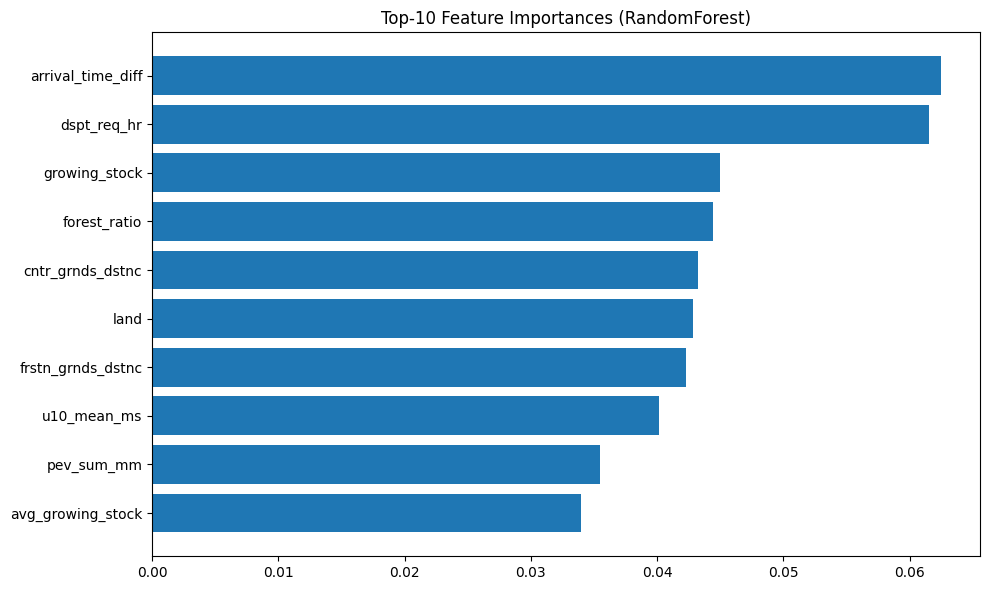

In [17]:
# === 4) RF 특성 중요도 Top-10 ===
import matplotlib.pyplot as plt

fi = pd.DataFrame({
    "feature": list(X_train.columns),
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop-10 Feature Importances:")
display(fi.head(10))

plt.figure(figsize=(10,6))
top = fi.head(10).iloc[::-1]
plt.barh(range(len(top)), top["importance"])
plt.yticks(range(len(top)), top["feature"])
plt.title("Top-10 Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()
